In [2]:
from keras.preprocessing.image import ImageDataGenerator
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Dropout,Input,MaxPooling2D,Conv2D,concatenate
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3

In [3]:
# function for creating a naive inception block
# function for creating a projected inception module
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
  # 1x1 conv
  conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
  # 3x3 conv
  conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
  conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
  # 5x5 conv
  conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
  conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
  # 3x3 max pooling
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
  # concatenate filters, assumes filters/channels last
  layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
  return layer_out

In [4]:
input = Input(shape=(224,224,3))
x = Conv2D(64,7,strides=2,padding="same",activation="relu")(input)
x = MaxPooling2D(3,strides=2,padding="same")(x)
x = Conv2D(64,1,activation="relu")(x)
x = Conv2D(192,3,padding="same",activation="relu")(x)
x = MaxPooling2D(3,strides=2,padding="same")(x)
x = inception_module(x,64,96,128,16,32,32)

In [5]:
classNames = ['cat', 'dog']
split = ['train[:70%]', 'train[70%:]']
 
trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)

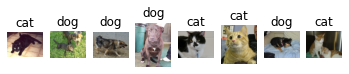

<Figure size 7200x7200 with 0 Axes>

In [6]:
i = 0
fig, ax = plt.subplots(1, 8)
for image, label in testDataset.take(8):
    ax[i].axis('off')
    ax[i].set_title(classNames[label])
    ax[i].imshow(image)
    i += 1
plt.figure(figsize=(100,100))
 
plt.show()

In [7]:
def preprocess(img, label):
    return tf.image.resize(img, [HEIGHT, WIDTH]) / 255, label

In [8]:
HEIGHT = 500
WIDTH = 500
split = ['train[:70%]', 'train[70%:]']
 
trainDataset, testDataset = tfds.load(name='cats_vs_dogs', split=split, as_supervised=True)
 
trainDataset = trainDataset.map(preprocess).batch(32)
testDataset = testDataset.map(preprocess).batch(32)

In [9]:
# x = [x for x,_ in testDataset ]
# y = [y for _,y in testDataset ]

In [10]:
# plt.imshow(x[0][0])
# y[0][0]

In [11]:
base_model = InceptionV3(input_shape=(500,500,3),include_top=False)
base_model.trainable = False

In [12]:
flatten_layer = tf.keras.layers.Flatten()#(base_model.output)
dense_layer_1 = tf.keras.layers.Dense(512, activation='relu')
dense_layer_2 = tf.keras.layers.Dense(128, activation='relu')
dense_layer_3 = tf.keras.layers.Dense(64, activation='relu')
dense_layer_4 = tf.keras.layers.Dense(32, activation='relu')
dense_layer_5 = tf.keras.layers.Dense(16, activation='relu')
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
model = tf.keras.models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    dense_layer_4,
    dense_layer_5,
    prediction_layer
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 flatten (Flatten)           (None, 401408)            0         
                                                                 
 dense (Dense)               (None, 512)               205521408 
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                5

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=["accuracy"])

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1,mode="auto")

In [16]:
%load_ext tensorboard

In [17]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(histogram_freq=1)

In [18]:
trainHistory = model.fit(trainDataset, epochs=3, validation_data=testDataset,callbacks=[callback,tensorboard_callback])
 


Epoch 1/3


C:\Users\Karan\miniconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


 83/509 [===>..........................] - ETA: 2:34 - loss: 27.9621 - accuracy: 0.8976

KeyboardInterrupt: 

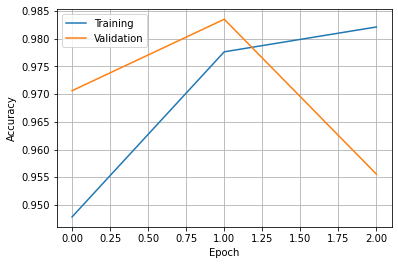

219/219 [==============================] - 12s 51ms/step - loss: 0.0721 - accuracy: 0.9556
0.07212021946907043
0.95558100938797


In [ ]:
plt.plot(trainHistory.history['accuracy'])
plt.plot(trainHistory.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.grid()
plt.show()
 
(loss, accuracy) = model.evaluate(testDataset)
print(loss)
print(accuracy)
 
model.save('model.h5')

In [6]:
model = keras.models.load_model('model.h5')

In [7]:
preds = model.predict(testDataset)

In [26]:
# import seaborn as sns
import numpy as np

In [9]:
y = np.concatenate([y for _, y in testDataset], axis=0)

In [10]:
conf_matrix = tf.math.confusion_matrix(y,np.where(preds > 0.5, 1, 0))

In [39]:
!wget https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg

--2022-03-02 11:29:15--  https://scx2.b-cdn.net/gfx/news/hires/2018/2-dog.jpg
Resolving scx2.b-cdn.net (scx2.b-cdn.net)... 138.199.9.104
Connecting to scx2.b-cdn.net (scx2.b-cdn.net)|138.199.9.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 415118 (405K) [image/jpeg]
Saving to: '2-dog.jpg'

     0K .......... .......... .......... .......... .......... 12%  133K 3s
    50K .......... .......... .......... .......... .......... 24%  188K 2s
   100K .......... .......... .......... .......... .......... 37%  521K 1s
   150K .......... .......... .......... .......... .......... 49%  676K 1s
   200K .......... .......... .......... .......... .......... 61%  309K 1s
   250K .......... .......... .......... .......... .......... 74% 1.00M 0s
   300K .......... .......... .......... .......... .......... 86%  976K 0s
   350K .......... .......... .......... .......... .......... 98%  342K 0s
   400K .....                                                 100% 11.

In [33]:
testimg = tf.keras.utils.load_img('pupp.jpg',target_size=(200,200))

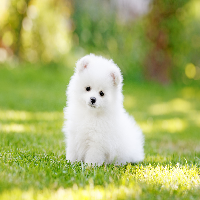

In [34]:
testimg

In [35]:
testimg = tf.keras.preprocessing.image.img_to_array(testimg)
img = np.expand_dims(testimg,axis = 0)
# x = [testimg]

In [36]:
np.round(model.predict(img)[0][0])


0.0